# Set up

In [1]:
import pandas as pd
import patsy
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Getting data

In [3]:
file_name = '../csvs/element_gameweek_features_v07.csv'

In [4]:
element_gameweek_df = pd.read_csv(file_name)

In [5]:
current_event = 38

In [6]:
last_train_event = 28

In [7]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [8]:
element_gameweek_df = pd.concat([
    element_gameweek_df[element_gameweek_df['element_type'] == i].fillna(
        element_gameweek_df[
            (element_gameweek_df['event'] <= last_train_event)
            & (element_gameweek_df['element_type'] == i)
        ].mean()).fillna(0)
    for i in range(1, 5)
])

In [9]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 30]

In [10]:
element_gameweek_df['is_keeper'] = element_gameweek_df['element_type'].apply(lambda x: 1 if x == 1 else 0)

In [11]:
element_gameweek_df['is_scorer'] = \
element_gameweek_df['rolling_avg_goals_scored_element'].apply(lambda x: 1 if x >= 0.47 else 0)

In [12]:
element_gameweek_df['is_assister'] = \
element_gameweek_df['rolling_avg_assists_element'].apply(lambda x: 1 if x >= 0.5 else 0)

In [25]:
element_gameweek_df['is_high_value'] = \
element_gameweek_df['value'].apply(lambda x: 1 if x >= 9.0 else 0)

# Modelling data

## Splitting data

In [26]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [27]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Scaling data

In [ ]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'has_high_points_ever_element',
        'total_points', 'minutes', 'rolling_value_points', 'is_keeper'
    ]
]

scaled_feature_cols

In [ ]:
scaled_df_train = element_gameweek_df_train.copy()
scaled_df_test = element_gameweek_df_test.copy()
scaled_df = element_gameweek_df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

element_gameweek_df_train[scaled_feature_cols] = scaled_df_train
element_gameweek_df_test[scaled_feature_cols] = scaled_df_test
element_gameweek_df[scaled_feature_cols] = scaled_df

## Building model

In [28]:
class FullRankOneHot(object):
    def __init__(self, reference=0):
        self.reference = reference

    # Called to generate a full-rank encoding
    def code_with_intercept(self, levels):
        return patsy.ContrastMatrix(np.eye(len(levels)),
                              ["[%s]" % (level,) for level in levels])

    # Called to generate a non-full-rank encoding. But we don't care,
    # we do what we want, and return a full-rank encoding anyway.
    # Take that, patsy.
    def code_without_intercept(self, levels):
        return self.code_with_intercept(levels)

In [29]:
list(element_gameweek_df.columns)

['safe_web_name',
 'element',
 'event',
 'fixture',
 'team',
 'opposition_team',
 'was_home',
 'is_sunday',
 'is_weekday',
 'is_early',
 'is_late',
 'element_type',
 'value',
 'rolling_value_points',
 'rolling_avg_total_points_element',
 'rolling_q3_total_points_element',
 'rolling_max_total_points_element',
 'has_high_points_ever_element',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rol

In [30]:
# formula = \
# '''
# total_points ~
# + C(element_type, FullRankOneHot)
# + C(team, FullRankOneHot)
# + C(opposition_team, FullRankOneHot)
# + was_home
# + value
# + rolling_avg_bonus_element
# + rolling_avg_big_chances_created_element
# + is_keeper:rolling_avg_big_chances_created_element
# + rolling_avg_saves_element
# + is_keeper:rolling_avg_saves_element
# + rolling_avg_goals_conceded_element
# + C(element_type, FullRankOneHot):rolling_avg_goals_conceded_element
# + rolling_avg_attempted_passes_element
# + is_keeper:rolling_avg_attempted_passes_element
# + rolling_avg_errors_leading_to_goal_attempt_element
# + C(element_type, FullRankOneHot):rolling_avg_errors_leading_to_goal_attempt_element
# + rolling_avg_penalties_saved_element
# + is_keeper:rolling_avg_penalties_saved_element
# + rolling_avg_yellow_cards_element
# + rolling_avg_minutes_element_p3
# + is_keeper:rolling_avg_minutes_element_p3
# + rolling_avg_total_points_element_p3
# + rolling_avg_goals_scored_opposition_team
# + C(element_type, FullRankOneHot):rolling_avg_goals_scored_opposition_team
# + rolling_q3_goals_conceded_opposition_team
# + C(element_type, FullRankOneHot):rolling_q3_goals_conceded_opposition_team
# + expected_total_points_against_opposition_team
# + rolling_avg_big_chances_element
# + is_keeper:rolling_avg_big_chances_element
# + rolling_avg_big_chances_scored_rate_element
# + is_keeper:rolling_avg_big_chances_scored_rate_element
# + rolling_avg_big_chances_assisted_rate_element
# + is_keeper:rolling_avg_big_chances_assisted_rate_element
# + rolling_avg_save_rate_element
# + is_keeper:rolling_avg_save_rate_element
# '''

In [36]:
formula = \
'''
total_points ~
+ C(element_type, FullRankOneHot)
+ C(team, FullRankOneHot)
+ C(opposition_team, FullRankOneHot)
+ was_home
+ value
+ is_high_value
+ rolling_q3_total_points_element
+ rolling_avg_bonus_element
+ rolling_avg_big_chances_created_element
+ rolling_avg_saves_element
+ is_keeper:rolling_avg_saves_element
+ rolling_avg_goals_conceded_element
+ rolling_avg_attempted_passes_element
+ rolling_avg_errors_leading_to_goal_attempt_element
+ rolling_avg_penalties_saved_element
+ is_keeper:rolling_avg_penalties_saved_element
+ rolling_avg_yellow_cards_element
+ rolling_avg_minutes_element_p3
+ rolling_avg_total_points_element_p3
+ rolling_avg_goals_scored_opposition_team
+ C(element_type, FullRankOneHot):rolling_avg_goals_scored_opposition_team
+ rolling_q3_goals_conceded_opposition_team
+ C(element_type, FullRankOneHot):rolling_q3_goals_conceded_opposition_team
+ expected_total_points_against_opposition_team
+ rolling_avg_big_chances_element
+ rolling_avg_big_chances_scored_rate_element
+ rolling_avg_big_chances_assisted_rate_element
+ rolling_avg_save_rate_element
'''

In [37]:
print(formula)


total_points ~
+ C(element_type, FullRankOneHot)
+ C(team, FullRankOneHot)
+ C(opposition_team, FullRankOneHot)
+ was_home
+ value
+ is_high_value
+ rolling_q3_total_points_element
+ rolling_avg_bonus_element
+ rolling_avg_big_chances_created_element
+ rolling_avg_saves_element
+ is_keeper:rolling_avg_saves_element
+ rolling_avg_goals_conceded_element
+ rolling_avg_attempted_passes_element
+ rolling_avg_errors_leading_to_goal_attempt_element
+ rolling_avg_penalties_saved_element
+ is_keeper:rolling_avg_penalties_saved_element
+ rolling_avg_yellow_cards_element
+ rolling_avg_minutes_element_p3
+ rolling_avg_total_points_element_p3
+ rolling_avg_goals_scored_opposition_team
+ C(element_type, FullRankOneHot):rolling_avg_goals_scored_opposition_team
+ rolling_q3_goals_conceded_opposition_team
+ C(element_type, FullRankOneHot):rolling_q3_goals_conceded_opposition_team
+ expected_total_points_against_opposition_team
+ rolling_avg_big_chances_element
+ rolling_avg_big_chances_scored_rate_ele

In [38]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [39]:
X.design_info.column_names

['Intercept',
 'C(element_type, FullRankOneHot)[1]',
 'C(element_type, FullRankOneHot)[2]',
 'C(element_type, FullRankOneHot)[3]',
 'C(element_type, FullRankOneHot)[4]',
 'C(team, FullRankOneHot)[1]',
 'C(team, FullRankOneHot)[2]',
 'C(team, FullRankOneHot)[3]',
 'C(team, FullRankOneHot)[4]',
 'C(team, FullRankOneHot)[5]',
 'C(team, FullRankOneHot)[6]',
 'C(team, FullRankOneHot)[7]',
 'C(team, FullRankOneHot)[8]',
 'C(team, FullRankOneHot)[9]',
 'C(team, FullRankOneHot)[10]',
 'C(team, FullRankOneHot)[11]',
 'C(team, FullRankOneHot)[12]',
 'C(team, FullRankOneHot)[13]',
 'C(team, FullRankOneHot)[14]',
 'C(team, FullRankOneHot)[15]',
 'C(team, FullRankOneHot)[16]',
 'C(team, FullRankOneHot)[17]',
 'C(team, FullRankOneHot)[18]',
 'C(team, FullRankOneHot)[19]',
 'C(team, FullRankOneHot)[20]',
 'C(opposition_team, FullRankOneHot)[1]',
 'C(opposition_team, FullRankOneHot)[2]',
 'C(opposition_team, FullRankOneHot)[3]',
 'C(opposition_team, FullRankOneHot)[4]',
 'C(opposition_team, FullRankOn

In [40]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Selecting features

In [41]:
estimator = Ridge(alpha=1)

selector = RFECV(estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
selector.fit(
    X,
    y.ravel()
)

Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 fe

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=None, solver='auto',
                      tol=0.001),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [42]:
sum(selector.support_)

74

In [43]:
selector.grid_scores_[-1]

-8.582171414759683

In [44]:
list(pd.Series(X.design_info.column_names)[selector.support_])

['C(element_type, FullRankOneHot)[1]',
 'C(element_type, FullRankOneHot)[2]',
 'C(element_type, FullRankOneHot)[3]',
 'C(element_type, FullRankOneHot)[4]',
 'C(team, FullRankOneHot)[1]',
 'C(team, FullRankOneHot)[2]',
 'C(team, FullRankOneHot)[3]',
 'C(team, FullRankOneHot)[4]',
 'C(team, FullRankOneHot)[5]',
 'C(team, FullRankOneHot)[6]',
 'C(team, FullRankOneHot)[7]',
 'C(team, FullRankOneHot)[8]',
 'C(team, FullRankOneHot)[9]',
 'C(team, FullRankOneHot)[10]',
 'C(team, FullRankOneHot)[11]',
 'C(team, FullRankOneHot)[12]',
 'C(team, FullRankOneHot)[13]',
 'C(team, FullRankOneHot)[14]',
 'C(team, FullRankOneHot)[15]',
 'C(team, FullRankOneHot)[16]',
 'C(team, FullRankOneHot)[17]',
 'C(team, FullRankOneHot)[18]',
 'C(team, FullRankOneHot)[19]',
 'C(team, FullRankOneHot)[20]',
 'C(opposition_team, FullRankOneHot)[1]',
 'C(opposition_team, FullRankOneHot)[2]',
 'C(opposition_team, FullRankOneHot)[3]',
 'C(opposition_team, FullRankOneHot)[4]',
 'C(opposition_team, FullRankOneHot)[5]',
 'C

In [45]:
X_sel = X[:,selector.support_]
X_train_sel = X_train[:,selector.support_]
X_test_sel = X_test[:,selector.support_]

## Tuning model

### GP tuner

In [139]:
space  = [
    Real(0.001, 0.1, 'log-uniform', name='learning_rate'),
    Real(0.5, 1.0, 'uniform', name='subsample'),
    Real(0.2, 1.0, 'uniform', name='colsample_bynode'),
    Real(0.0001, 100, 'log-uniform', name='reg_lambda'),
    Integer(2, 6, name='max_depth'),
    Integer(100, 200, name='n_estimators')
]

In [140]:
gp_model = XGBRegressor(objective='reg:squarederror')

@use_named_args(space)
def objective(**params):
    gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            gp_model,
            X,
#             X_sel,
            y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [141]:
res_gp_arr = []
for i in range(1, 5):
    print('minimisation iteration', i)
    res_gp = gp_minimize(objective, space, n_calls=50, verbose=2)
    res_gp_arr.append(res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.6347
Function value obtained: 12.4290
Current minimum: 12.4290
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.6475
Function value obtained: 8.6146
Current minimum: 8.6146
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.9488
Function value obtained: 10.4879
Current minimum: 8.6146
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.1687
Function value obtained: 8.5751
Current minimum: 8.5751
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 3.0617
Function value obtained: 8.6776
Current minimum: 8.5751
Iterati

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 3.0482
Function value obtained: 8.5152
Current minimum: 8.4843
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 3.0219
Function value obtained: 8.5151
Current minimum: 8.4843
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 2.8130
Function value obtained: 8.4946
Current minimum: 8.4843
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 2.5943
Function value obtained: 8.4928
Current minimum: 8.4843
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 2.8799
Function value obtained: 8.5027
Current minimum: 8.4843
Iteration No: 46 started. Sea

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 1.9564
Function value obtained: 8.5021
Current minimum: 8.4977
Iteration No: 33 started. Searching for the next optimal point.
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.7696
Function value obtained: 8.5365
Current minimum: 8.4977
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 2.1042
Function value obtained: 8.5095
Current minimum: 8.4977
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 2.1420
Function value obtained: 8.5476
Current minimum: 8.4977
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 2.5110
Function value obtained: 8.5371
Current minimum: 8.4977
Iteration No: 37 started. Sea

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 3.3939
Function value obtained: 8.5934
Current minimum: 8.5127
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 7.8985
Function value obtained: 8.6127
Current minimum: 8.5127
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.9554
Function value obtained: 8.5515
Current minimum: 8.5127
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 2.0987
Function value obtained: 8.5706
Current minimum: 8.5127
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.8393
Function value obtained: 8.5292
Current minimum: 8.5127
Iteration No: 28 started. Sea

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 1.9004
Function value obtained: 8.5577
Current minimum: 8.5320
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 3.2382
Function value obtained: 8.5230
Current minimum: 8.5230
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 2.1949
Function value obtained: 8.6710
Current minimum: 8.5230
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 2.5701
Function value obtained: 8.7450
Current minimum: 8.5230
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 2.2371
Function value obtained: 8.6204
Current minimum: 8.5230
Iteration No: 19 started. Sea

In [143]:
for i in res_gp_arr:
    print(i.fun)
print('\n')
for i in res_gp_arr:
    print(i.x)

8.484331333211571
8.48643585247465
8.497253791427282
8.485532691940326


[0.019200370273100075, 1.0, 0.2, 1.0735740123379287, 6, 200]
[0.02941812306501078, 1.0, 0.2, 100.0, 4, 169]
[0.07827650450057456, 1.0, 0.2, 0.0001, 2, 100]
[0.026646012524034753, 1.0, 0.2, 0.0001, 4, 158]


### Grid search

In [59]:
?XGBRegressor

In [145]:
learning_rate = [0.045, 0.0475, 0.05, 0.0525, 0.055]
subsample = [0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1.0]
colsample_bynode = [0.1, 0.125, 0.15, 0.2, 0.25, 0.3]
reg_lambda = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
max_depth = [2, 3, 4, 5, 6]

gs_parameters = {
    'learning_rate': learning_rate,
    'subsample': subsample,
    'colsample_bynode': colsample_bynode,
    'reg_lambda': reg_lambda,
    'max_depth': max_depth
}

In [ ]:
gs_df_arr = []
for i in range(0, 10):
    print('grid search', i)
    gs = GridSearchCV(
        XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100
        ),
        gs_parameters,
        scoring='neg_mean_squared_error',
        refit=False,
        cv=ps,
        return_train_score=True,
        error_score=100, n_jobs=1, verbose=1)
    gs.fit(X, y.ravel())
    
    gs_df = pd.DataFrame(gs.cv_results_)
    gs_df_arr.append(gs_df)

grid search 0
Fitting 1 folds for each of 6300 candidates, totalling 6300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 6300 out of 6300 | elapsed: 91.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 1
Fitting 1 folds for each of 6300 candidates, totalling 6300 fits


[Parallel(n_jobs=1)]: Done 6300 out of 6300 | elapsed: 91.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 2
Fitting 1 folds for each of 6300 candidates, totalling 6300 fits


In [ ]:
gs_df = pd.concat(gs_df_arr)[[
    'param_learning_rate',
    'param_subsample',
    'param_reg_lambda',
    'param_max_depth',
    'param_colsample_bynode',
    'mean_test_score',
    'mean_train_score'
]]

gs_group_df = gs_df.groupby([
    'param_learning_rate',
    'param_subsample',
    'param_reg_lambda',
    'param_max_depth',
    'param_colsample_bynode'
],
    as_index=True
).describe().reset_index()

In [ ]:
gs_group_df[gs_group_df['mean_test_score']['mean'] > -8.46]

# Evaluating model

## XGBoost

In [121]:
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    subsample=0.9,
    learning_rate=0.05,
    colsample_bynode=0.2,
    reg_lambda=0.75,
    max_depth=4,
)

model.fit(X_train, y_train.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.2, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=0.75, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.9, verbosity=1)

In [122]:
# get predictions for test set
y_pred = model.predict(X_test).flatten()

# calculate cross entropy loss for test set
test_loss = (
    mean_absolute_error(y_test, y_pred),
    mean_squared_error(y_test, y_pred),
    r2_score(y_test, y_pred)
)
test_loss

(2.0799349681937205, 8.447198908990892, 0.11903325759315175)

In [123]:
# refit model on all data
model_full = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    subsample=0.9,
    learning_rate=0.05,
    colsample_bynode=0.2,
    reg_lambda=0.75,
    max_depth=4,
)

model_full.fit(X, y.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.2, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=0.75, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.9, verbosity=1)

In [124]:
# get predictions for whole set
y_pred_full = model_full.predict(X).flatten()

# calculate cross entropy loss for test set
test_loss_full = (
    mean_absolute_error(y, y_pred_full),
    mean_squared_error(y, y_pred_full),
    r2_score(y, y_pred_full)
)
test_loss_full

(1.9544453375758821, 7.521073723313239, 0.19999372354292622)

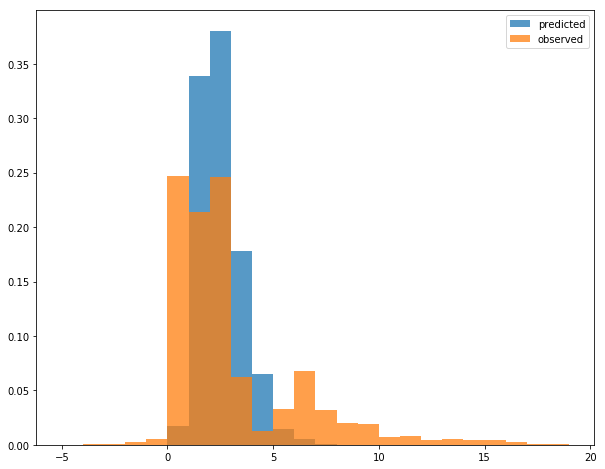

In [125]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

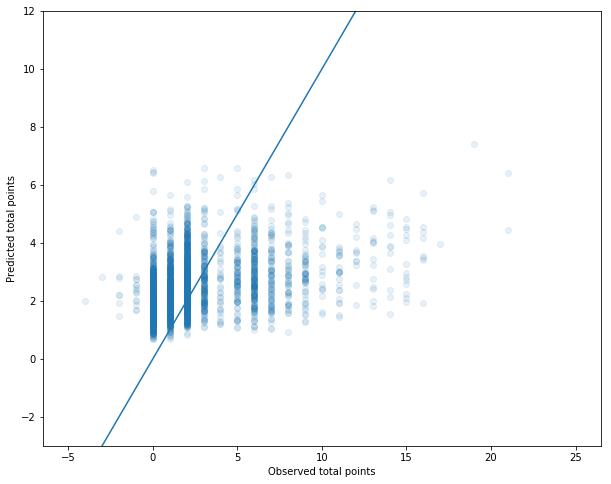

In [126]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Summary

In [127]:
pd.DataFrame([
    ('XGBoost', test_loss[0], test_loss[1], test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,XGBoost,2.079935,8.447199,0.119033


In [128]:
pd.DataFrame([
    ('XGBoost', test_loss_full[0], test_loss_full[1], test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,XGBoost,1.954445,7.521074,0.199994
